In [1]:
import network
import data
import solver

import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:

def initialize_nets():
    D = 400

    teacher1 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher2 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher3 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher4 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)

    teacher_c = network.ContextTeacher(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign')

    student1 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student2 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student3 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student4 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)

    student_c = network.ContextStudent(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign')
    
    return [teacher1, teacher2, teacher3, teacher4], [student1, student2, student3, student4], teacher_c, student_c

In [3]:
dataloader = data.iid.TransientRLTask(batch_size = 1, seq_len = [2,2,2,2], input_dim = 400, identical = False)

In [4]:
teachers, students, teacher_cs, student_cs = initialize_nets()
_, students_base, _, student_cs_base = initialize_nets()


In [6]:
print(teacher_cs.layers[0].weight)
print(student_cs.layers[0].weight)


Parameter containing:
tensor([[-0.3046, -2.6676,  2.3400,  0.5646]])
Parameter containing:
tensor([[-0.2555,  0.6582,  0.5390,  1.1411]], requires_grad=True)


In [7]:

curriculum_solver=solver.TwoPhaseContextSolver(teachers=teachers, \
                                               students = students, context_teacher=teacher_cs, \
                                               context_student=student_cs, dataloader = dataloader, logdir = None)


In [8]:
curriculum_solver.train(nums_iter = [20000,20000], lrs = [(10,1),(0.1,1)], update_frequency=100)

In [9]:
base_solver = solver.TwoPhaseContextSolver(teachers = teachers, \
                                          students = students_base, context_teacher = teacher_cs, 
                                          context_student = student_cs_base, dataloader = dataloader, logdir = None)

In [10]:
base_solver.train(nums_iter =[0, 40000], lrs = [(10,1),(0.1,1)], update_frequency = 100)

Text(0.5, 1.0, 'ns')

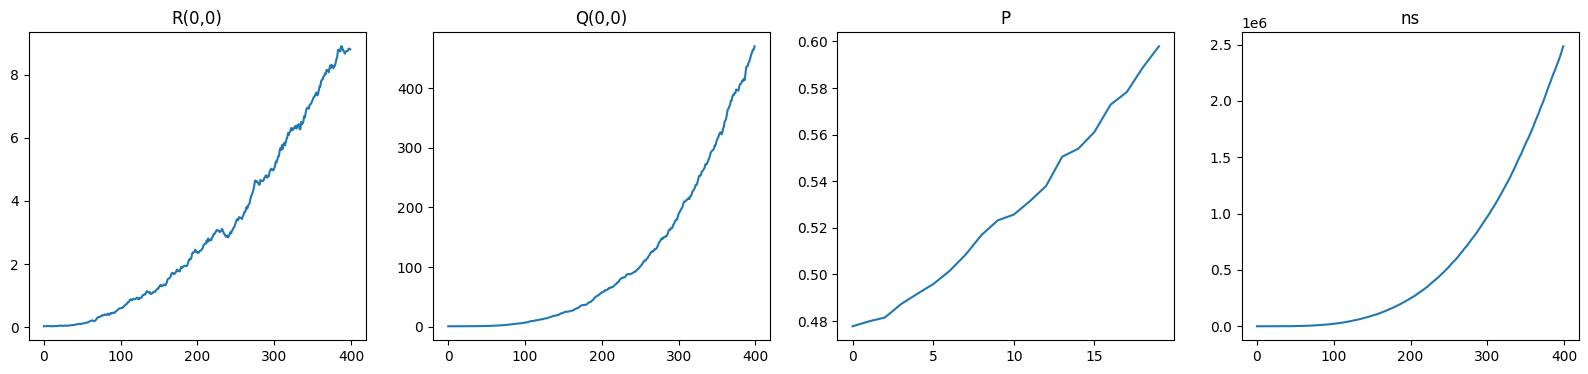

In [12]:

fig2 = plt.figure(figsize=(20, 4))
ax1 = plt.subplot(141)
R=[k[0,0] for k in base_solver.history['phase2']['R']]
ax1.plot(R[:])
ax1.set_title('R(0,0)')

ax2 = plt.subplot(142)
Q=[k[0,0] for k in base_solver.history['phase2']['Q']]
ax2.plot(Q[:])
ax2.set_title('Q(0,0)')

ax3 = plt.subplot(143)
P=base_solver.history['phase2']['P']
#PC=curriculum_solver.history['phase2']['P']
ax3.plot(P[:20])
#ax3.plot(PC[:])
ax3.set_title('P')

ax4 = plt.subplot(144)
ns=base_solver.history['phase2']['norm_student']
ax4.plot(ns[:])
ax4.set_title('ns')

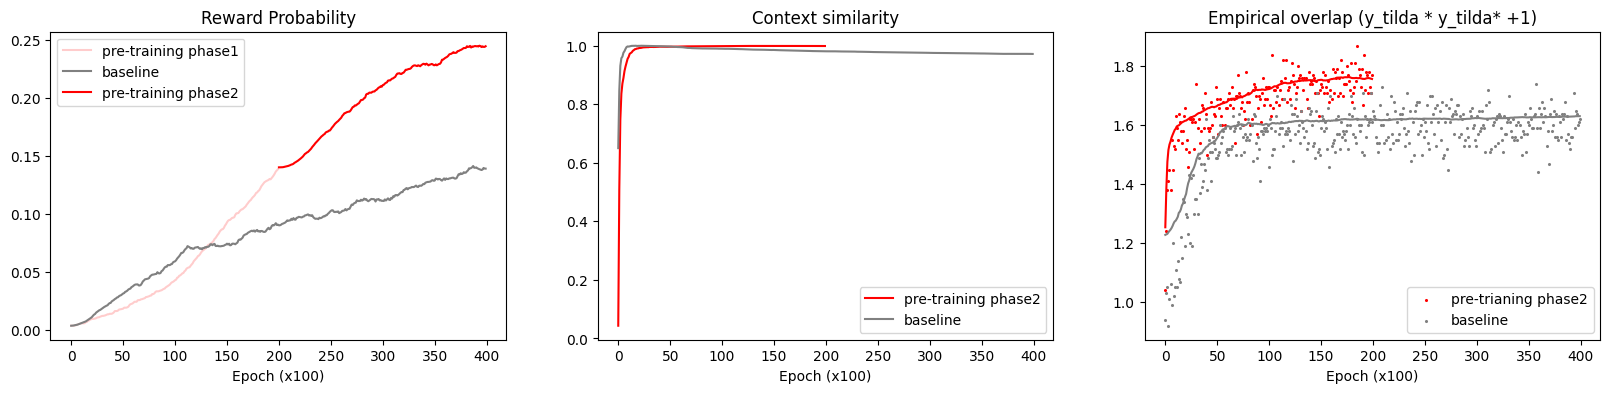

In [13]:
fig = plt.figure(figsize=(20, 4))
ax1 = plt.subplot(131)
ax1.plot(curriculum_solver.history['phase1']['reward_rate'], label = 'pre-training phase1', c= 'r', alpha = 0.2)
ax1.plot(base_solver.history['phase2']['reward_rate'], label = 'baseline', c= 'gray')
len_phase1 = len(curriculum_solver.history['phase1']['reward_rate'])
len_phase2 = len(curriculum_solver.history['phase2']['reward_rate'])
ax1.plot(np.arange(len_phase1, len_phase1+len_phase2),
         curriculum_solver.history['phase2']['reward_rate'], label = 'pre-training phase2', c= 'r')

ax1.set_title('Reward Probability')
ax1.set_xlabel('Epoch (x100)')

plt.legend()
ax2 = plt.subplot(132)
ax2.plot(curriculum_solver.history['phase2']['context_similarity'], label = 'pre-training phase2', c = 'r')
ax2.plot(base_solver.history['phase2']['context_similarity'], label = 'baseline', c= 'gray')
ax2.set_title('Context similarity')
ax2.set_xlabel('Epoch (x100)')
plt.legend()

ax3 = plt.subplot(133)


curriculum_empirical_overlap = curriculum_solver.history['phase2']['overlap']
base_empirical_overlap = base_solver.history['phase2']['overlap']
                                                       
curriculum_P = curriculum_solver.history['phase2']['P']
base_P = base_solver.history['phase2']['P']

ax3.scatter(np.arange(len(curriculum_empirical_overlap)),curriculum_empirical_overlap, s= 1.5, c = 'r', label = 'pre-trianing phase2')
ax3.scatter(np.arange(len(base_empirical_overlap)),base_empirical_overlap, c= 'gray', label = 'baseline', s=1.5)

ax3.plot(np.power(np.array(curriculum_P),2) +1,  c = 'r', )
ax3.plot(np.power(np.array(base_P),2)+1, c= 'gray', )

ax3.set_title('Empirical overlap (y_tilda * y_tilda* +1)')
ax3.set_xlabel('Epoch (x100)')
plt.legend()